## HW11 - Assignment 1 - zn352, Using Geopandas to locate CUSP in US Census Tracts

In [1]:
# download data and save to my local dir
import os
os.system("curl -O http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nycb2010_16d.zip")
os.system("unzip " + "nycb2010_16d.zip -d "+ '/home/cusp/zn352/PUI2016_zn352/HW11_Geopandas')

256

In [2]:
# read the file in geopandas
from geopandas import GeoDataFrame
shape_path='nycb2010_16d/nycb2010.shp'
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.head()

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
0,50009001000,5,Staten Island,1000,000900,244589.603884,2508.948115,"POLYGON ((962269.1260375977 173705.5001831055,..."
1,50020011000,5,Staten Island,1000,002001,111006.286826,1345.886422,"POLYGON ((964642.2676391602 161835.2651977539,..."
2,50027001000,5,Staten Island,1000,002700,150406.766022,1703.381172,"POLYGON ((963363.1168212891 167356.3336181641,..."
3,50040001000,5,Staten Island,1000,004000,141296.561149,1511.173743,"POLYGON ((960069.9965820312 161953.6936035156,..."
4,50064001000,5,Staten Island,1000,006400,200784.983607,1978.243852,"POLYGON ((963023.891784668 158246.7521972656, ..."


In [42]:
# extract only Brooklyn shape
ct_latlon = ct_shape[ct_shape['BoroName']=='Brooklyn']

In [29]:
# convert the coordinates into lat/lon
from fiona.crs import from_epsg
ct_latlon.crs = from_epsg(2263) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
geometry = ct_latlon.to_crs(epsg=4326).geometry
geometry.head()
# note: can use lambda as another method
# ct_latlon['geometry'] = geometry.applymap(lambda x:shapely.geometry.Polygon(x))

5037    POLYGON ((-74.00659158337982 40.65561273365177...
5038    POLYGON ((-73.99514512602698 40.69877384567195...
5039    POLYGON ((-73.99270830309769 40.69809925981344...
5040    POLYGON ((-73.98514306089652 40.69488514296981...
5041    POLYGON ((-73.98305147125492 40.69837793354038...
Name: geometry, dtype: object

In [52]:
# converted data
ct_latlon.drop(['geometry'], inplace=True, axis=1)
ct_latlon['geometry'] = geometry
ct_latlon.head()

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
5037,30002001000,3,Brooklyn,1000,000200,208484.989566,2097.493132,POLYGON ((-74.00659158337982 40.65561273365177...
5038,30003011000,3,Brooklyn,1000,000301,63365.958361,1006.913933,POLYGON ((-73.99514512602698 40.69877384567195...
5039,30005011000,3,Brooklyn,1000,000501,116303.194723,1431.900698,POLYGON ((-73.99270830309769 40.69809925981344...
5040,30011001000,3,Brooklyn,1000,001100,54802.306859,951.657541,POLYGON ((-73.98514306089652 40.69488514296981...
5041,30015001000,3,Brooklyn,1000,001500,79196.530872,1129.348482,POLYGON ((-73.98305147125492 40.69837793354038...


In [69]:
# find out CUSP coordinates and create a point 
import shapely
CUSP = shapely.geometry.Point(-73.985176,40.694421)

In [83]:
# Loop over the Brookly polygons to find in which geometry the polygon is contained
for ct in ct_latlon.geometry:
    if shapely.geometry.asShape(ct).contains(CUSP) == True:
        CUSP_polygon = ct
        print ('CUSP is contained in %s' %ct)

CUSP is contained in POLYGON ((-73.98514306089652 40.69488514296981, -73.98516822415829 40.69435907630051, -73.98615943608057 40.69437490429107, -73.98616900025644 40.69492406481108, -73.98514306089652 40.69488514296981))


In [84]:
# find the index of that contained polygon
ct_latlon.loc[(ct_latlon.geometry == CUSP_polygon)]

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
5040,30011001000,3,Brooklyn,1000,001100,54802.306859,951.657541,POLYGON ((-73.98514306089652 40.69488514296981...


In [167]:
from pandas import DataFrame
import matplotlib.pylab as plt
plt.style.use('bmh')
%matplotlib inline

In [164]:
len(ct_latlon)

9682

In [114]:
# create a numpy array to choose one from ten polygons
import numpy as np
S = np.array([i*10 for i in range(0,969)])

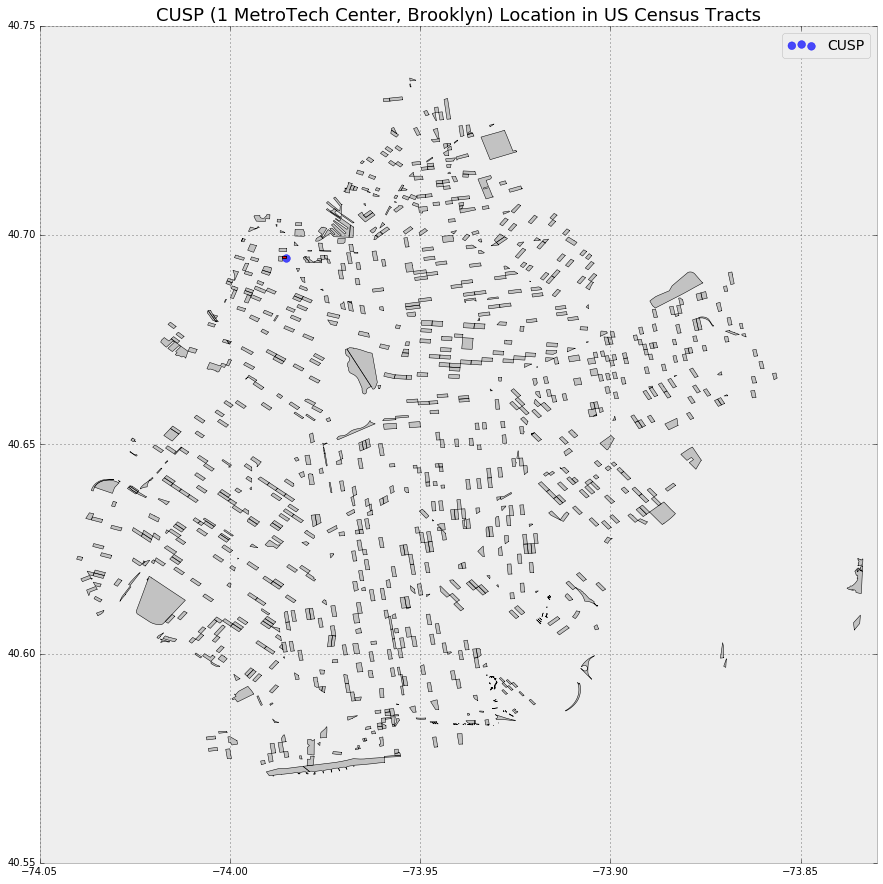

In [173]:
# Plot one every 10 polygons of brooklyn (using the geopandas datafame method plot) 
# and overplot the location of cusp as a point (using pylab.scatter) 
# Overplot also the census track that contains cusp in red (using the geopandas datafame method plot)

f, ax = plt.subplots(figsize=(15,15))
ax.set_xlim(-74.05, -73.83)
ct_latlon.iloc[S].plot(alpha=0.4, linewidth=0.5, ax=ax, color='grey')
plt.scatter(-73.985176,40.694421, alpha=0.7, marker='o', color='blue', s=60, label='CUSP')
ct_latlon.loc[(ct_latlon.geometry == CUSP_polygon)].plot(alpha=1, linewidth=0.8, ax=ax, color='red')
ax.set_title('CUSP (1 MetroTech Center, Brooklyn) Location in US Census Tracts', fontsize=18)
ax.legend(fontsize=14)

In [160]:
# zoom in the CUSP area
ct_latlon_Zoom=(ct_latlon[ct_latlon
                           .centroid
                           .apply(lambda c:c.x>-74.0 and c.x<-73.95 and c.y>40.66 and c.y<40.71)])

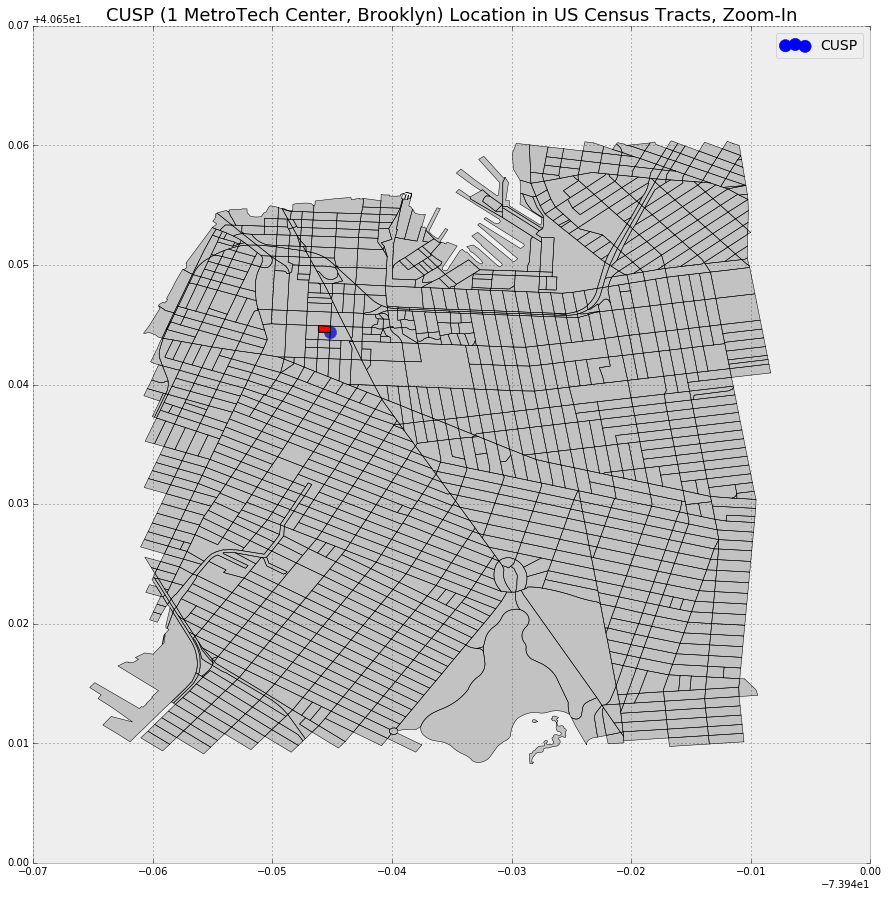

In [176]:
# plot again to have a clearer view
f, ax = plt.subplots(figsize=(15,15))
ct_latlon_Zoom.plot(alpha=0.4,linewidth=0.5,ax=ax, color='grey')
plt.scatter(-73.985176,40.694421, alpha=1, marker='o', color='blue', s=150, label='CUSP')
ct_latlon.loc[(ct_latlon.geometry == CUSP_polygon)].plot(alpha=1,linewidth=0.8,ax=ax, color='red')
ax.set_title('CUSP (1 MetroTech Center, Brooklyn) Location in US Census Tracts, Zoom-In', fontsize=18)
ax.legend(fontsize=14)